# MeasurementLoop

This notebook introduces the `MeasurementLoop`, which is one of three methods used to perform measurements. The three measurement methods are in increasing levels of complexity:

- `qcodes.dataset.do_nd.dond` and its variations `do1d` and `do2d`.  
  These are function calls that perform basic N-dimensional sweeps, measuring a list of parameters in the innermost loop.  
  It is a wrapper around the `Measurement` class
- `qcodes.dataset.measurement_loop.MeasurementLoop` can perform more complex measurements, including conditional measurements, nested measurements. It can perform arbitrary python code in a measurement. 
The `MeasurementLoop` relies on a fixed order in which parameters are measured (examples below). This fixed order reduces the amount of explicit code needed.
It is a wrapper around the `Measurement` class
- `qcodes.dataset.measurements.Measurement` is the most explicit type of measurement.  
All parameters that are swept / measured must be explicitly registered before the measurement starts, as well as preferably their array shapes.  
The `Measurement` can perform arbitrary python code. It further allows parameters to be measured in arbitrary order.

The `MeasurementLoop` therefore lies in complexity between the `dond` and `Measurement`, and should be able to meet the majority of measurement needs while minimizing the amount of explicit definitions. For example, in contrast to `Measurement`, the `MeasurementLoop` does not need any parameters to be registered.

We will start with basic examples of the `MeasurementLoop` and then go over some more advanced features  

## Basic measurement

In [15]:
import numpy as np
import time

from qcodes.dataset import (
    MeasurementLoop, 
    Sweep,
    initialise_or_create_database_at, 
    load_or_create_experiment
)
from qcodes.instrument import Parameter, ManualParameter

initialise_or_create_database_at('database.db')
load_or_create_experiment('measurement_loop_experiment');

We start by creating a set parameter and a get parameter that returns a random value

In [2]:
set_parameter = ManualParameter('set_parameter')
random_parameter = Parameter('random_parameter', get_cmd=np.random.rand)
print(f'{random_parameter()=}')

random_parameter()=0.42399278190478207


We now perform a basic measurement: sweeping one parameter (`set_parameter`) and measuring another (`random_parameter`):

In [3]:
with MeasurementLoop('basic_measurement') as msmt:
    for val in Sweep(set_parameter, start=0, stop=10, num=11):
        msmt.measure(random_parameter)

print('Finished measurement')

Starting experimental run with id: 2. 
Finished measurement


Let's break this code down line-by-line.
```Python
with MeasurementLoop('basic_measurement') as msmt:
```  
> Here the `with` statement instantiates the `MeasurementLoop` inside a context manager. Everything inside this block is part of the measurement. We use the variable `msmt` to refer to the instantiated `MeasurementLoop` as we will use it to measure parameters later on.  
> We're also supposed to give the measurement a name, in this case `'basic_measurement'`

```Python
for set_val in Sweep(set_parameter, start=0, stop=10, num=11):
```
> We use a `Sweep` object to register in the `MeasurementLoop` that we want to sweep `set_parameter` with 11 points spaced between 0 and 10. The `MeasurementLoop` now also knows that everything inside this loop has a dimension of (11, ).  
> Notice that we are using a standard python loop, so we can access the iterated values `set_val`.  
> Notice also that the value of `set_parameter` is being updated as we sweep over it.

```Python
msmt.measure(random_parameter)
```
> Here we measure `random_parameter` inside the sweep. The `MeasurementLoop` automatically registers `random_parameter` once it's measured for the first time.

### Comparison to dond

Since this is a very basic measurement, it can also performed in less code using `dond` as follows:

In [4]:
from qcodes.dataset.do_nd import dond, LinSweep
dataset = dond(LinSweep(set_parameter, 0, 10, 11), random_parameter)

Starting experimental run with id: 3. Using 'qcodes.dataset.dond'


It can even be performed by the simpler do1d:

In [5]:
from qcodes.dataset.do_nd import do1d
dataset = do1d(set_parameter, 0, 10, 11, 0, random_parameter)

Starting experimental run with id: 4. Using 'qcodes.dataset.do1d'


At this point you might wonder what the use is of `MeasurementLoop`. The point is that the `MeasurementLoop` can also perform significantly more complex types of measurements, as we will go into later.

### Comparison to `Measurement`

The same basic measurement can also be performed by the `Measurement` class as follows:

In [6]:
from qcodes.dataset.measurements import Measurement
context_meas = Measurement(name='basic_measurement_Measurement_class')

# Register the independent parameter...
context_meas.register_parameter(set_parameter)
# ...then register the dependent parameter
context_meas.register_parameter(random_parameter, setpoints=(set_parameter,))

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 10, 11):
        set_parameter(set_v)
        get_v = random_parameter()
        datasaver.add_result((set_parameter, set_v),
                             (random_parameter, get_v))

Starting experimental run with id: 5. 


There are some clear differences with the code of the `MeasurementLoop`. - All set/get parameters involved in the measurement need to be registered beforehand, as well as their relation.
- When a parameter is swept over, it needs to be explicitly set.
- Any parameter that is measured also needs to be added, along with the corresponding set value(s).

These differences all make the `Measurement` more explicit than both the `MeasurementLoop` and `dond/do1d/do2d`. On the one hand, this makes it more cumbersome to write a measurement. But on the other hand, this allows greater flexibility. For example, we could have set `set_parameter` to another value instead of the iterated value `set_v`; this would not have been possible using the other methods.

The `MeasurementLoop` is supposed to lie somewhere in between `dond` and `Measurement`, enabling a wide variety of measurements while requiring a minimal amount of explicit code to be written.

## A more complex measurement example

Here we perform a slightly more complex measurement. We perform a 2D sweep and again measure `random_parameter` inside it. However, we now count the number of times that it is above 0.5. Each time it is above 0.5, we sleep for 100 ms. after each inner loop we register how many times it was above 0.5.

In [7]:
with MeasurementLoop('conditional_measurement_example') as msmt:
    for set_val1 in Sweep(set_parameter, np.logspace(1, 3, 51)):
        above_half = 0  # We initialize a counter here

        # Notice that we don't need to sweep a parameter
        for set_val2 in Sweep(np.arange(10), 'inner_set_parameter'):
            random_val = msmt.measure(random_parameter)

            # We increment the counter if the random_val is above 0.5
            if random_val > 0.5:
                above_half += 1
                # Let's also sleep a bit
                time.sleep(0.1)

        # Notice that we don't need a parameter to measure this
        msmt.measure(above_half, 'above_half')

Starting experimental run with id: 6. 


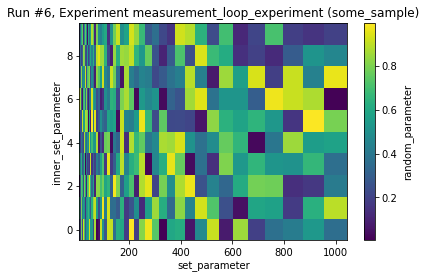

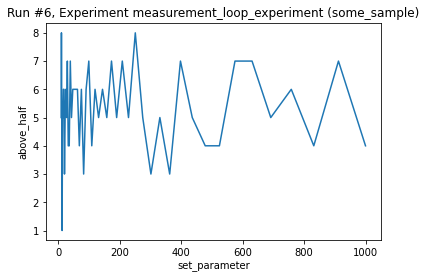

In [8]:
from qcodes.dataset.plotting import plot_by_id
plot_by_id(msmt.dataset.run_id);

As can be seen, the measurement code did not increase much in complexity even though we started performing more complex measurements. this measurement cannot be performed using `dond`, though it can still be performed by `Measurement`.

One surprising fact from the above measurement is that we didn't need to define new parameters for the inner sweep and for the measurement recording how many times `random_parameter` is above half. This is a feature of the `MeasurementLoop`: parameters aren't needed for sweeps and measurements! This can significantly simplify creating complex measurements.


## Nested measurements

One big feature of the `MeasurementLoop` is that one can nest measurements. This is largely because we don't have to define our parameters beforehand. Here we show an example:

In [9]:
with MeasurementLoop('outer_measurement') as outer_msmt:
    for set_val1 in Sweep(range(10), 'outer_sweep'):

        with MeasurementLoop('inner_measurement') as inner_msmt:
            for set_val2 in Sweep(range(10), 'inner_sweep'):
                inner_msmt.measure(random_parameter)

Starting experimental run with id: 7. 


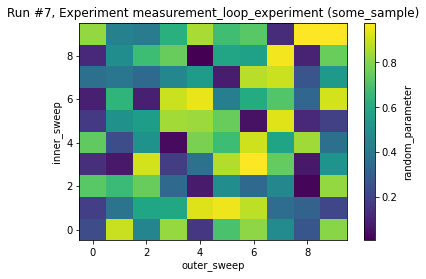

In [10]:
from qcodes.dataset.plotting import plot_by_id
plot_by_id(outer_msmt.dataset.run_id);

When we instantiate the inner measurement, it sees that another measurement is already running, and so it realizes that it is part of this larger measurement and so attaches to it. It will therefore use the dimensionality of the outer measurement.

You can again ask yourself why this is useful. One big reason is that this allows us to functionalize measurements. For example, we can create a function `retune_device()` that performs a complex retuning sequence, in this case finding the minimum of a 2D quadratic:

In [11]:
from scipy import optimize


def retune_device():
    with MeasurementLoop('retune_device') as msmt:
        # Create a random minimal point
        x0 = msmt.measure(2 * (np.random.rand() - 0.5), 'x0')
        y0 = msmt.measure(2 * (np.random.rand() - 0.5), 'y0')
        print(f'{x0=:.3f}, {y0=:.3f}', end=', \t')

        minimization_function = lambda x: (x[0] - x0)**2 + (x[1] - y0)**2

        intermediary_results = []
        max_iter = 100
        optimize.minimize(
            minimization_function, 
            x0=(100*np.random.rand(), 100*np.random.rand()),
            options={'maxiter': max_iter},
            callback=intermediary_results.append
        )

        for k in Sweep(range(max_iter), 'iteration'):
            if k >= len(intermediary_results):
                msmt.step_out()  # See section "Fixed measurement order"
                break

            msmt.measure(intermediary_results[k][0], 'x')
            msmt.measure(intermediary_results[k][1], 'y')
            msmt.measure(x0 - intermediary_results[k][0], 'x_error')
            msmt.measure(y0 - intermediary_results[k][1], 'y_error')
            
        print(
            f'x_error = {x0 - intermediary_results[-1][0]:.4g}, '
            f'y_error = {y0 - intermediary_results[-1][1]:.4g}')
    return msmt

ModuleNotFoundError: No module named 'scipy'

Here we perform the retuning sequence and plot the results:

In [ ]:
msmt = retune_device()

Starting experimental run with id: 31. 
x0=-0.676, y0=0.351, 	x_error = -6.712e-08, y_error = -6.954e-08


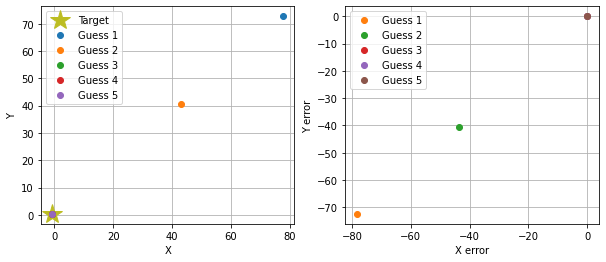

In [ ]:
dataset = msmt.dataset.to_xarray_dataarray_dict()
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ax = axes[0]
ax.plot(dataset['x0'], dataset['y0'], '*', ms=20, label='Target', color='C8')
for k, (x, y) in enumerate(zip(dataset['x'], dataset['y']), start=1):
    ax.plot(x, y, 'o', label=f'Guess {k}')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid('on')

ax = axes[1]
for k, (x, y) in enumerate(zip(dataset['x_error'], dataset['y_error']), start=1):
    ax.plot(x, y, 'o', label=f'Guess {k}', color=f'C{k}')
ax.legend()
ax.set_xlabel('X error')
ax.set_ylabel('Y error')
ax.grid('on')

Now, since we can nest measurements, we can simply incorporate it as a function in another measurement:

In [ ]:
with MeasurementLoop('measurement_with_retuning') as msmt:
    for k in range(11):
        result = retune_device()

        msmt.measure(random_parameter)

Starting experimental run with id: 32. 
x0=0.606, y0=-0.378, 	x_error = 1.036e-07, y_error = 1.664e-06
x0=-0.908, y0=-0.610, 	x_error = -2.148e-08, y_error = -4.82e-09
x0=-0.821, y0=0.242, 	x_error = -1.613e-06, y_error = 2.737e-06
x0=-0.090, y0=0.307, 	x_error = 2.077e-06, y_error = -4.658e-06
x0=-0.927, y0=0.470, 	x_error = 1.126e-08, y_error = 7.831e-08
x0=0.364, y0=-0.038, 	x_error = -1.531e-07, y_error = -2.273e-07
x0=-0.878, y0=0.987, 	x_error = 1.254e-06, y_error = 5.796e-07
x0=0.754, y0=-0.254, 	x_error = 2.951e-07, y_error = 3.297e-07
x0=0.855, y0=0.030, 	x_error = 2.321e-07, y_error = 1.216e-06
x0=0.198, y0=-0.337, 	x_error = 8.037e-08, y_error = 7.971e-08
x0=0.445, y0=0.292, 	x_error = 4.155e-09, y_error = 4.147e-09


The ability to turn a measurement into a function that can then be used within other measurements allows the experimentalist to modularize measurements. This can help once measurements become more complex

## Fixed measurement order of parameters

One of the main reasons why the `MeasurementLoop` is able to make so much of the code implicit is because it assumes a fixed order in which parameters are swept / measured. This needs to be adhered to, or things can break. This restriction can be illustrated with the following example.

For this example we first use the `Measurement`. We sweep a parameter from 0 to 10 in integer steps. If the integer is odd, we measure `random_parameter` which returns a random value. However, if it's even, we measure `fixed_parameter` which always returns 42.

Importantly, the first parameter that is being measured in every sweep iteration changes between `random_parameter` and `fixed_parameter`

In [ ]:
from qcodes.dataset.measurements import Measurement
context_meas = Measurement(name='varied_parameter_order_measurement')

# Register the independent parameter...
context_meas.register_parameter(set_parameter)
# ...then register the dependent parameter
context_meas.register_parameter(random_parameter, setpoints=(set_parameter,))

# We also add a second parameter that always returns 42
fixed_parameter = Parameter('fixed_parameter', get_cmd = lambda: 42)
context_meas.register_parameter(fixed_parameter, setpoints=(set_parameter,))

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 10, 11):
        set_parameter(set_v)

        if set_v % 2:
            get_v = random_parameter()
            datasaver.add_result((set_parameter, set_v),
                                (random_parameter, get_v))
        else:
            get_v = fixed_parameter()
            datasaver.add_result((set_parameter, set_v),
                                (fixed_parameter, get_v))


Starting experimental run with id: 33. 


We see that both parameters are measured perfectly fine

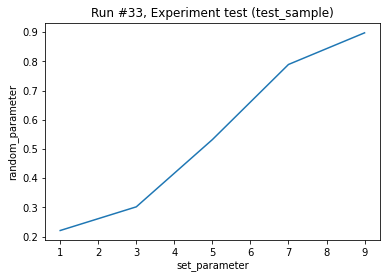

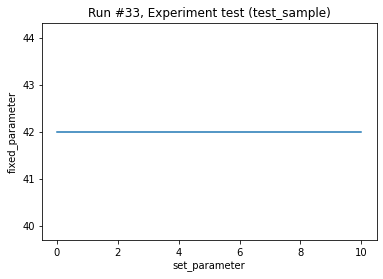

In [ ]:
plot_by_id(datasaver.dataset.run_id);

We now try the same using the `MeasurementLoop`.

In [ ]:
with MeasurementLoop('varied_order_measurement_loop') as msmt:
    for set_v in Sweep(range(11), 'sweep_values'):
        if set_v % 2:
            msmt.measure(random_parameter)
        else:
            msmt.measure(fixed_parameter)

Measurement error RuntimeError(Wrong measurement at action_indices (0, 0). Expected: fixed_parameter. Received: random_parameter) - varied_order_measurement_loop


Starting experimental run with id: 34. 


RuntimeError: Wrong measurement at action_indices (0, 0). Expected: fixed_parameter. Received: random_parameter

Lo and behold, an error appeared. This is because it expects the first measurement to be `fixed_parameter`, which was measured during the first iteration, but instead the second iteration it measures `random_parameter`.

This problem can be solved by explicitly telling the `MeasurementLoop` which is the first or second measurement by adding `msmt.skip`.
In this example,  `random_parameter` has a `msmt.skip()` before it, indicating that another parameter is usually measured first (though not this time) and so it's actually the second parameter being measured.

In [ ]:
with MeasurementLoop('varied_order_measurement_loop') as msmt:
    for set_v in Sweep(range(11), 'sweep_values'):
        if set_v % 2:
            msmt.skip()
            msmt.measure(random_parameter)
        else:
            msmt.measure(fixed_parameter)
            msmt.skip()

Starting experimental run with id: 36. 


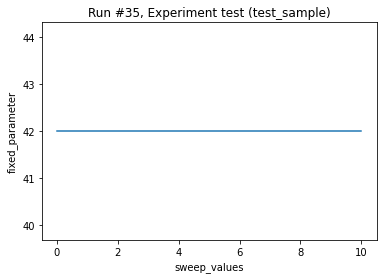

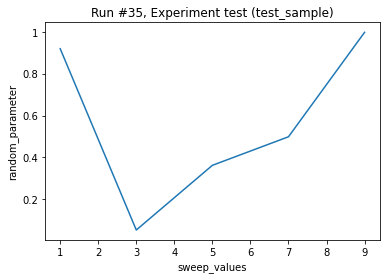

In [ ]:
plot_by_id(msmt.dataset.run_id);

A `break` statement is the second situation in which the `MeasurementLoop` needs an explicit signal to ensure the measurement order is adhered to. The reason is because unlike a context manager, a for-loop has no way of knowing when the loop has been prematurely exited, and so it won't be able to perform the necessary actions when exiting a `Sweep`.

In [ ]:
with MeasurementLoop('varied_order_measurement_loop') as msmt:
    for set_v in Sweep(range(11), 'sweep_values'):
        if (set_v+1) % 5:
            print(f'{set_v=}, continuing measurement')
            msmt.measure(random_parameter)
        else:
            print(f'{set_v=}, exiting prematurely using `msmt.step_out`')
            msmt.step_out()
            break

Starting experimental run with id: 39. 
set_v=0, continuing measurement
set_v=1, continuing measurement
set_v=2, continuing measurement
set_v=3, continuing measurement
set_v=4, exiting prematurely using `msmt.step_out`


In this case we see that the `break` statement is preceded by `msmt.step_out`. This indicates to the `MeasurementLoop` that it has to take the necessary actions because the Sweep is exited.

## `Sweep` functionalities

Sweeping over a sequence of values in a `MeasurementLoop` is done using the `Sweep` object. It can sweep over an explicit sequence of values, or it can be given arguments to generate a sequence from.

### Sweeping a parameter

A parameter can be swept over by passing the parameter as the first argument. Here we create a sweep of parameter "set_parameter" over values "[1, 2, 3, 4]"

In [ ]:
parameter_sweep = Sweep(set_parameter, [1,2,3,4])
parameter_sweep

Sweep(parameter=set_parameter, length=4)

In this case, the parameter value is automatically changed during the measurement:

In [ ]:
with MeasurementLoop('sweep_set_parameter_measurement') as msmt:
    for val in parameter_sweep:
        print(f'{set_parameter()=}')

Starting experimental run with id: 41. 
set_parameter()=1
set_parameter()=2
set_parameter()=3
set_parameter()=4


### Sweeping without a parameter

It is also possible to create a `Sweep` without a parameter. In this case, no parameter value is updated. In this case it's necessary to pass along a "name"

In [ ]:
Sweep([1,2,3], name='sweep_without_parameter')

Sweep('sweep_without_parameter', length=3)

### Generating a sequence

In the previous example we saw how you can create a sweep out of a pre-existing sequence. The `Sweep` also has convenient methods to generate a sequence using (keyword) arguments.  
The following keyword arguments are identical to `np.linspace`

In [ ]:
sweep = Sweep(set_parameter, start=0, stop=10, num=11)
sweep.sequence

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

We can also give a `step`, in which case it behaves like `np.arange`, with the exception that here the last value is included

In [ ]:
sweep = Sweep(set_parameter, start=0, stop=10, step=2)
sweep.sequence

array([ 0,  2,  4,  6,  8, 10])

One can also use the current value of a "set_parameter" to generate a sequence. Here we tell it to create 11 points in a range of 5 below to above it's current value

In [ ]:
set_parameter(2)
sweep = Sweep(set_parameter, around=5, num=11)
sweep.sequence

array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

Or here we choose 11 points from whatever it's current value is to 12

In [ ]:
set_parameter(2)
sweep = Sweep(set_parameter, stop=12, num=11)
sweep.sequence

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

### Sweep arguments

The most common types of sweeps can also be created without using keyword arguments. For example:

In [ ]:
Sweep(set_parameter, 0, 10, 11)

Sweep(parameter=set_parameter, length=11)

is equivalent to

In [ ]:
Sweep(set_parameter, start=0, stop=10, num=11)

Sweep(parameter=set_parameter, length=11)

A full list of argument combinations can be found in the docstring of `Sweep.transform_args_to_kwargs`

## Additional features

### Value masking

The `MeasurementLoop` also provides the ability to mask the value of an object during the measurement. For example

In [12]:
get_parameter = ManualParameter('get_parameter', initial_value=2)
print(f'Initial value {get_parameter()=}')

with MeasurementLoop('masking_measurement') as msmt:
    msmt.mask(get_parameter, 9)
    
    print(f'Masked value {get_parameter()=}')

    for val in Sweep(set_parameter, range(5)):
        msmt.measure(get_parameter)

print(f'Value after measurement finished: {get_parameter()=}')

Initial value get_parameter()=2
Starting experimental run with id: 8. 
Masked value get_parameter()=9
Value after measurement finished: get_parameter()=2


This can be especially useful when measurements are encapsulated in functions, as it allows to set parameters to specific values during the measurement, knowing that it will be reset after.

The unmasking of a parameter happens after a measurement is complete, even if the measurement fails.

### Masking dictionaries and object attributes

We just saw that it's possible to mask a parameter value. It is also possible to mask two other elements:
- keys in dictionaries
- attributes of objects

Here we show the two examples

In [13]:
# First create a dummy class
class MyObject:
    object_attribute = 42


In [14]:

my_object= MyObject()
print(f'Initial object value {my_object.object_attribute=}')

d = dict(key1=12, key2=13, key3=14)
print(f'Initial dictionary {d=}')

with MeasurementLoop('masking_dictionary_and_object') as msmt:
    msmt.mask(my_object, object_attribute=999)
    msmt.mask(d, key2=999)

    print(f'Masked object value {my_object.object_attribute=}')
    print(f'Masked dictionary {d=}')

print(f'Final object value {my_object.object_attribute=}')
print(f'Final dictionary {d=}')

Initial object value my_object.object_attribute=42
Initial dictionary d={'key1': 12, 'key2': 13, 'key3': 14}
Starting experimental run with id: 9. 
Masked object value my_object.object_attribute=999
Masked dictionary d={'key1': 12, 'key2': 999, 'key3': 14}
Final object value my_object.object_attribute=42
Final dictionary d={'key1': 12, 'key2': 13, 'key3': 14}


### Measuring without a parameter

Most previous examples showed how we can measure a `Parameter` in a `MeasurementLoop`. However, this is not a requirement. Just as one can create a `Sweep` without a parameter, so can one also measure things that are not a parameter.

In [ ]:
with MeasurementLoop('measure_non_parameters') as msmt:
    for k in Sweep(range(5), 'sweep'):
        msmt.measure(42, 'measure_value')
        msmt.measure({'val1': 1, 'val2': 2}, 'measure_dict')

        # One can also measure a function that returns a dict
        def random_int(min_val=1, max_val=50):
            return {
                'val1': np.random.randint(min_val, max_val),
                'val2': np.random.randint(min_val, max_val)
            }
        msmt.measure(random_int, 'measure_callable')

Starting experimental run with id: 47. 


### Measuring same parameter multiple times

One feature of the `MeasurementLoop` that is not possible in the original `Measurement` is that the same parameter can be swept/measured at multiple different points:

In [ ]:
with MeasurementLoop('measure_same_parameter') as msmt:
    for k in Sweep(range(10), 'sweep_parameter'):
        msmt.measure(random_parameter)
        msmt.measure(random_parameter)
msmt.dataset

Starting experimental run with id: 49. 


measure_same_parameter #49@C:\Users\Serwan\experiments.db
---------------------------------------------------------
sweep_parameter - numeric
random_parameter - numeric
random_parameter_1 - numeric

As can be seen, this creates two different measurement arrays. The second measurement automatically appends an index to distinguish its name from the original measurement array.

This is a useful feature especially when encapsulating measurements in functions. In this case it could very well occur that the same parameter is measured at multiple different locations